In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install chart_studio

# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_4:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import chart_studio.plotly as py
import plotly.graph_objs as go
from collections import Counter

## 1.1 Reading Data

In [0]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [0]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [0]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [0]:
print("Number of resources required by id-p069063:",resource_data.groupby('id').get_group('p069063')['quantity'].sum())

Number of resources required by id-p069063: 13


### Summary
The number of datapoints are more in resource_data because a project might need more than one resources. 
Example: we can see for the project id -p069063, it required 13 resources.

# 1.2 Data Analysis

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


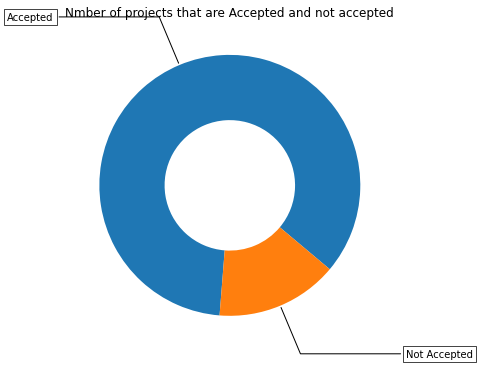

In [0]:
# This code was taken from this page:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

### Summary

85% of total projects i.e 92706 of 109248 are approved for funding
15 % of total projects failed to secure funding.
It is an Imbalanced dataset.

### 1.2.1 Univariate Analysis: School State

In [0]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

'''# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = temp['state_code'],
        z = temp['num_proposals'].astype(float),
        locationmode = 'USA-states',
        text = temp['state_code'],
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "% of pro")
    ) ]

layout = dict(
        title = 'Project Proposals % of Acceptance Rate by US States',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='us-map-heat-map')
'''

'# How to plot US state heatmap: https://datascience.stackexchange.com/a/9620\n\nscl = [[0.0, \'rgb(242,240,247)\'],[0.2, \'rgb(218,218,235)\'],[0.4, \'rgb(188,189,220)\'],            [0.6, \'rgb(158,154,200)\'],[0.8, \'rgb(117,107,177)\'],[1.0, \'rgb(84,39,143)\']]\n\ndata = [ dict(\n        type=\'choropleth\',\n        colorscale = scl,\n        autocolorscale = False,\n        locations = temp[\'state_code\'],\n        z = temp[\'num_proposals\'].astype(float),\n        locationmode = \'USA-states\',\n        text = temp[\'state_code\'],\n        marker = dict(line = dict (color = \'rgb(255,255,255)\',width = 2)),\n        colorbar = dict(title = "% of pro")\n    ) ]\n\nlayout = dict(\n        title = \'Project Proposals % of Acceptance Rate by US States\',\n        geo = dict(\n            scope=\'usa\',\n            projection=dict( type=\'albers usa\' ),\n            showlakes = True,\n            lakecolor = \'rgb(255, 255, 255)\',\n        ),\n    )\n\nfig = go.Figure(data=dat

In [0]:
# This code was taken from this page:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


In [0]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.xticks(rotation=90)
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [0]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    #accepted project count
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    #total number of submitted project count based on the category
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

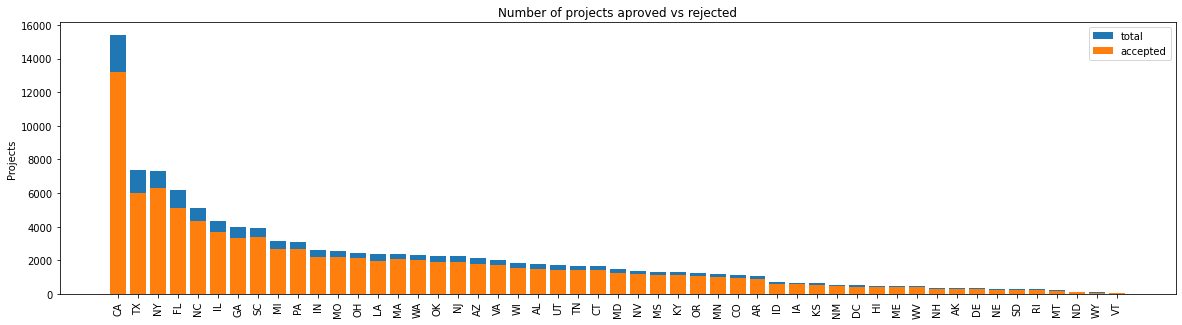

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [0]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

#### Summary:

1. All states have greater than 80% success rate in project approval. In the plot we can see there are huge variability in #. of project approved for CA to VT.
2. In term of highest % approvals, DE shows highest rate(89.7959%) and VT is showing lowest rate(80%)
3. However interms of total project submission, CA is showing highest no of approval which is 13205(85.8136) and VT is showing least no of approval which is 64(80%).

### 1.2.2 Univariate Analysis: teacher_prefix

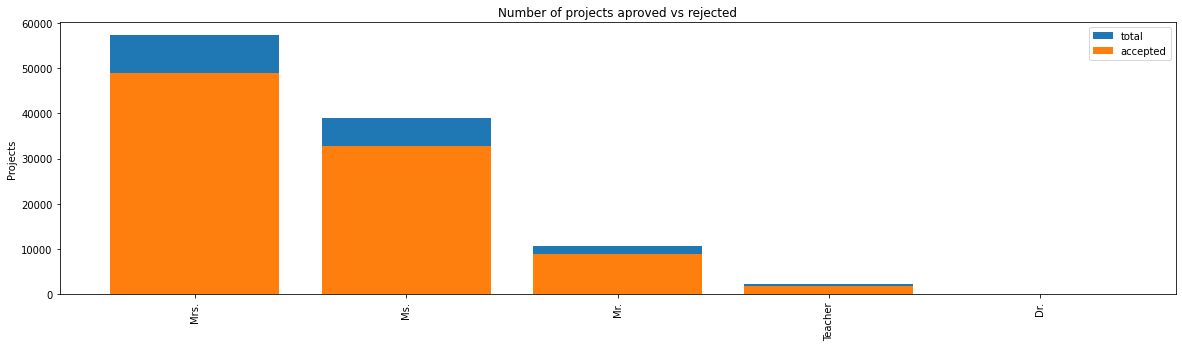

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [0]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

#### Summary

1. Teacher with Mrs prefix submitted highest number of projects( 57269) with highest approval rate(85.5559%) and Teacher with Dr. prefix submitted lowest number of projects (13) with less approval rate(69.2308%).
2. Females submitted more projects than mans.

### 1.2.3 Univariate Analysis: project_grade_category

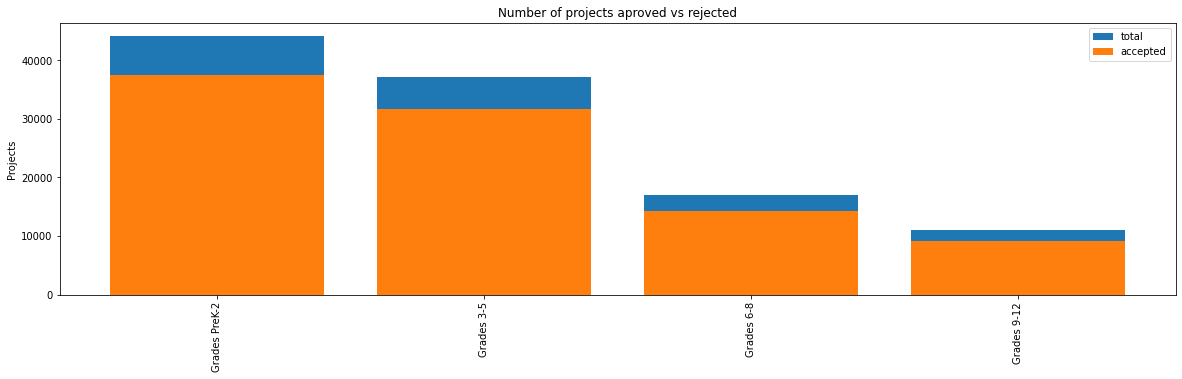

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [0]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

#### Summary
As we can see in plot, Projects for Grades 3-5 is having highest approval rate(85.4377).
and projects for Grades PreK-2 is having highest no. of approval which is 37536.

### 1.2.4 Univariate Analysis: project_subject_categories

In [0]:
# Preprocessing Categorical Features: project_subject_categories

catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [0]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports


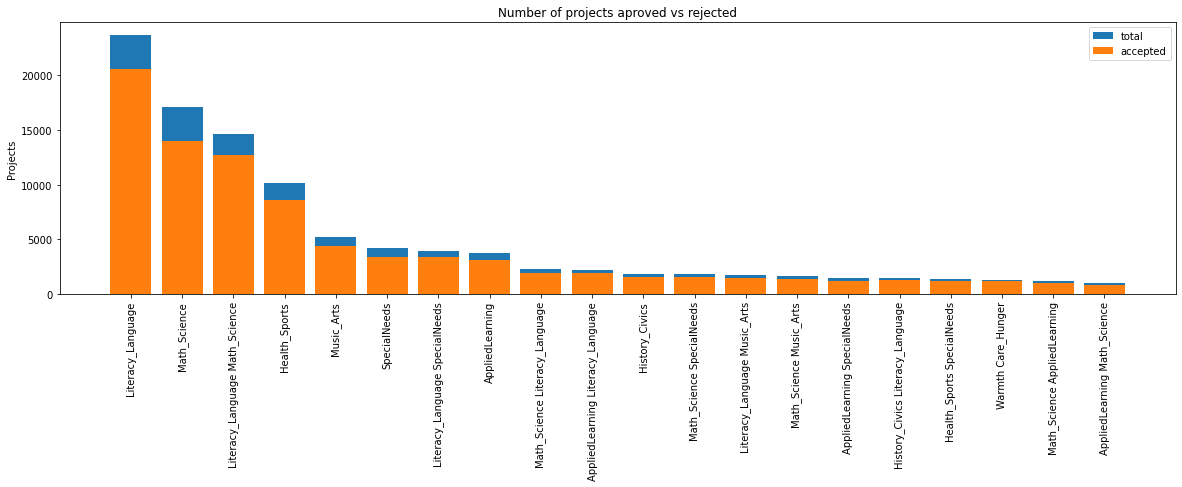

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [0]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

#### Summary:

Project for category "Literacy_Language" is having highest no of approval which is 23655 and project for category "History_Civics Literacy_Language" is having highest approval rate(89.4441%). Project for AppliedLearning Math_Science is having least no of approved project.

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

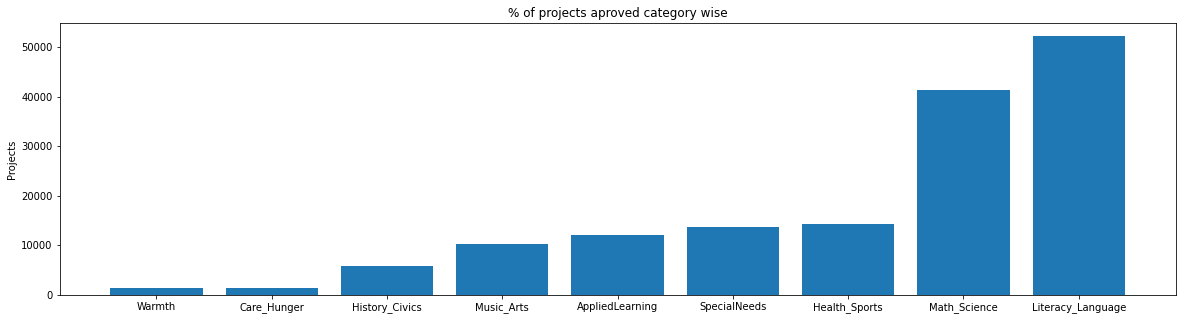

In [0]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [0]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


#### Summary:
1. After breaking individual categories, project for categories "Literacy_Language"is having highest no. of projectapproval that is 52239 and Warmth is having least no. of project approval(1388).

### 1.2.5 Univariate Analysis: project_subject_subcategories

In [0]:
# Preprocessing Categorical Features: project_subject_subcategories

sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [0]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports


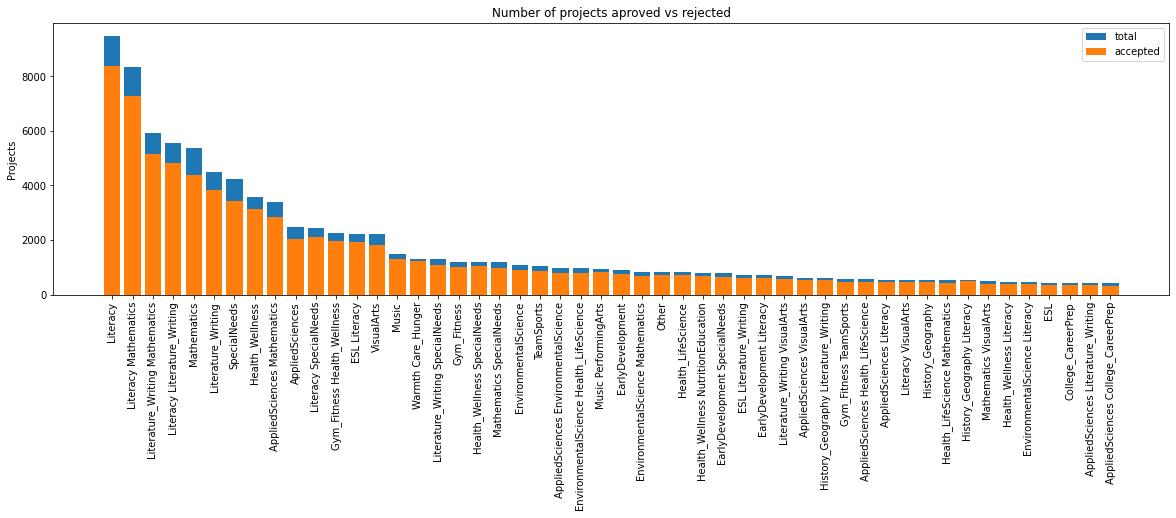

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [0]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

#### Summary:

Project for subcategory Literacy is having highest no of project approval rate which is 88.2458 with highest no. of approved project 8371. and subcategory "AppliedSciences College_CareerPrep" is having least no of approved project which is 330.

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

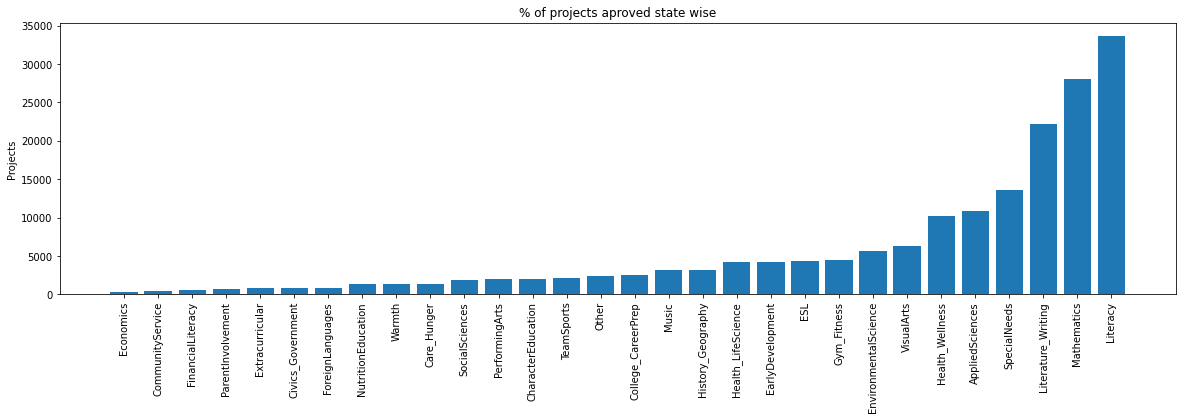

In [0]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.xticks(rotation=90)
plt.show()


In [0]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


#### Summary:
1. After breaking individual subcategories, project for subcategories "Literacy"is having highest no. of project submission that is 33700 and  project for subcategories "Economics" is having least no. of project submission.

### 1.2.6 Univariate Analysis: Text features (Title)

4     19979
5     19677
3     18691
6     14824
7     10631
2      8733
8      7289
9      5383
10     3968
1        31
11       30
12       11
13        1
Name: project_title, dtype: int64


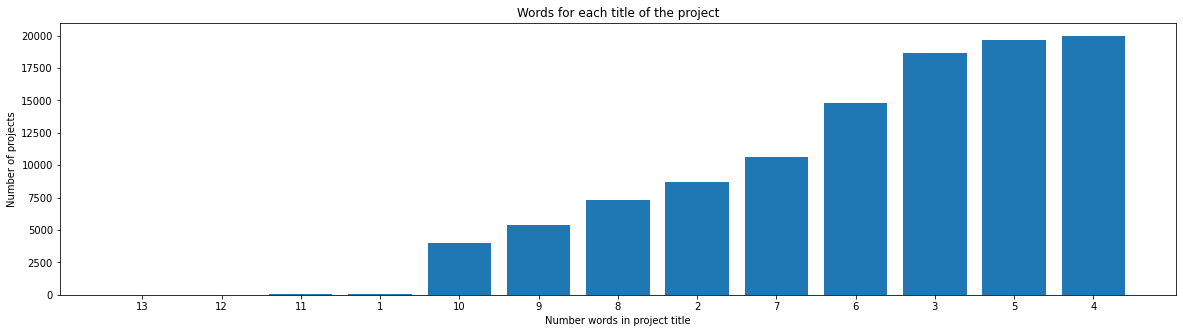

In [0]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
print(word_count)
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of projects')
plt.xlabel('Number words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [0]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

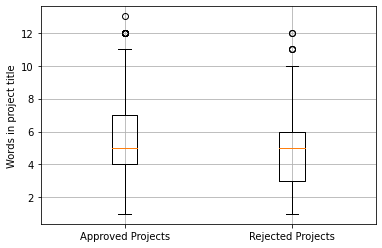

In [0]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

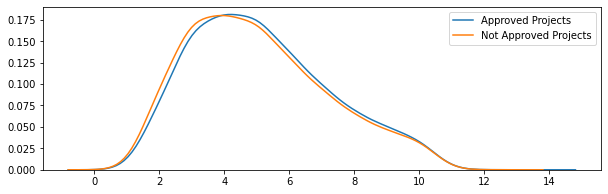

In [0]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

#### Summary
1. As we can see in bar plot, Most of the projects have 3,4,5 words in their title, only one project has 13 words in it's title.
2. 19979(max) projects having 4 words in their title.
3. From the box plot, Mean of approved project and non approved projects are almost same which is 5.
4. In boxplot, Approved project having threshold of no of words is 1 to 11 and for non approved,it is 1 to 10.

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

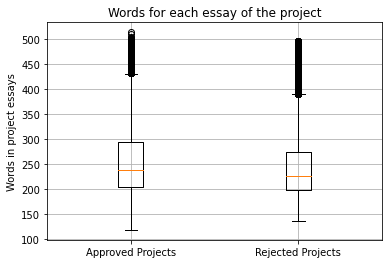

In [0]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

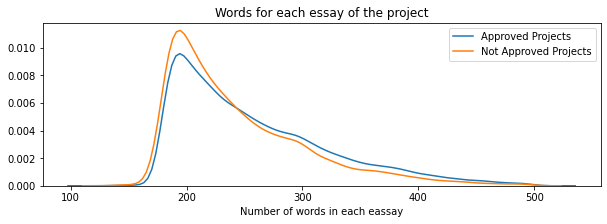

In [0]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

#### Summary:
1. 19979(max) projects having 4 words in their title.
2. From the box plot, Mean of approved project and non approved projects are almost same which is in between 230 to 240.
3. In boxplot, Approved project having threshold of no of words is 125 to 425 and for non approved,it is 140 to 500.
4. In KDE plot,Number of words in essay of approved projects are slightly than the rejected project.

### 1.2.8 Univariate Analysis: Cost per project

In [0]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [0]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [0]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

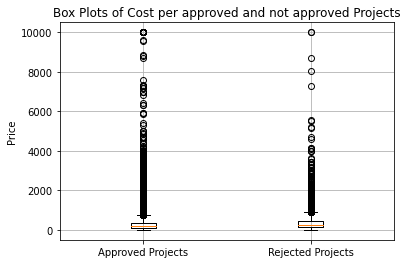

In [0]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

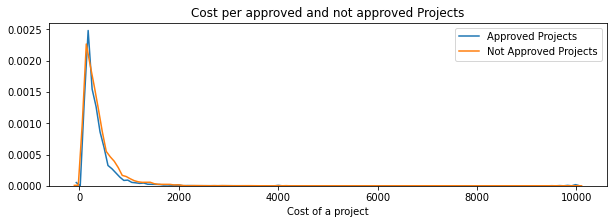

In [0]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

In [0]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

# If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

#### Summary:
1. As we can see in percentile table, percentile of non approved projects is slightly heigher than approved project.
2. In Box plot, the maximum price of project is 1000$.
3. In CDF, Cost of approved project is overlaped on rejected projects. But in some places rejected project cost is slightly higher than approved projects.

<h3><font color='red'>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>

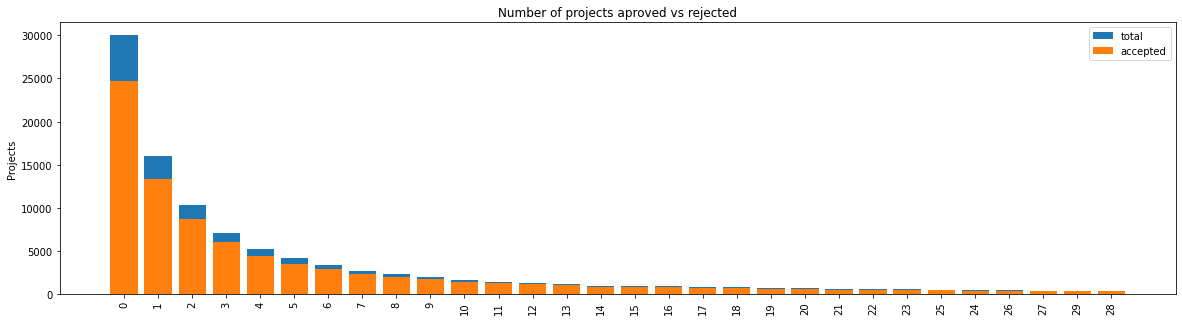

   teacher_number_of_previously_posted_projects  ...       Avg
0                                             0  ...  0.821350
1                                             1  ...  0.830054
2                                             2  ...  0.841063
3                                             3  ...  0.843460
4                                             4  ...  0.845423

[5 rows x 4 columns]
    teacher_number_of_previously_posted_projects  ...       Avg
24                                            24  ...  0.902004
26                                            26  ...  0.849438
27                                            27  ...  0.893401
29                                            29  ...  0.908108
28                                            28  ...  0.889205

[5 rows x 4 columns]


In [0]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved',top=30)

#### Summary:
1. In bar plot, As we can see that most no of project submiited by those teachers who did not submit any project before which is 30014 with high 82.1350% approved rate.
2. Teacher who submitted 24 projects before have high approve rate(90%).

### 1.2.10 Univariate Analysis: project_resource_summary

#.Words  #.Projects
11     10551
12      7920
13      7384
14      6775
15      6221
16      5870
17      5403
18      4915
19      4487
20      4152
36      3996
21      3821
22      3427
35      3222
23      3130
24      2938
25      2781
26      2583
34      2530
33      2521
28      2448
27      2370
32      2267
30      2203
29      2201
31      2151
10       365
9        274
8        190
7         62
6         46
5         35
4          6
37         1
137        1
67         1
Name: project_resource_summary, dtype: int64


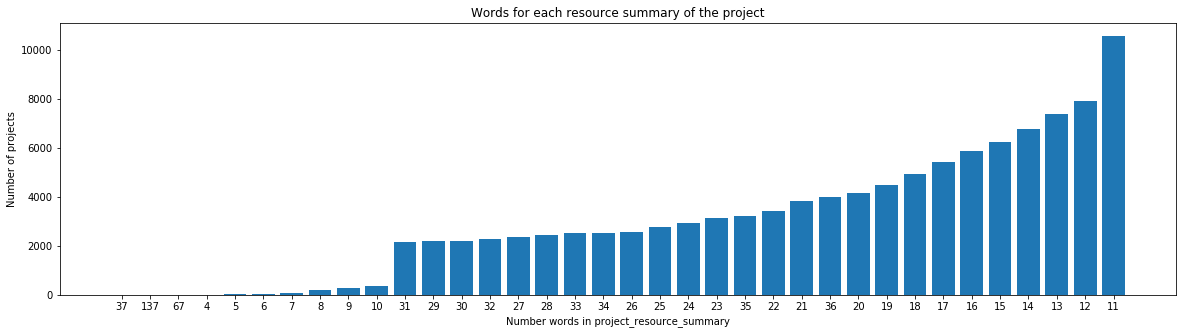

In [27]:
# How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count_prs = project_data['project_resource_summary'].str.split().apply(len).value_counts()
print("#.Words  #.Projects")
print(word_count_prs)
word_dict_prs = dict(word_count_prs)
word_dict_prs = dict(sorted(word_dict_prs.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict_prs))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict_prs.values()))

plt.ylabel('Number of projects')
plt.xlabel('Number words in project_resource_summary')
plt.title('Words for each resource summary of the project')
plt.xticks(ind, list(word_dict_prs.keys()))
plt.show()

In [0]:
approved_prs_word_count = project_data[project_data['project_is_approved']==1]['project_resource_summary'].str.split().apply(len)
approved_prs_word_count = approved_prs_word_count.values

rejected_prs_word_count = project_data[project_data['project_is_approved']==0]['project_resource_summary'].str.split().apply(len)
rejected_prs_word_count = rejected_prs_word_count.values

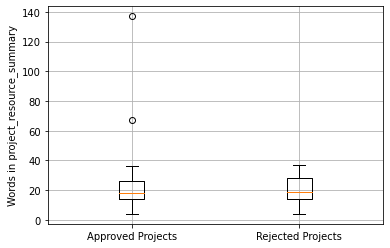

In [0]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_prs_word_count, rejected_prs_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project_resource_summary')
plt.grid()
plt.show()

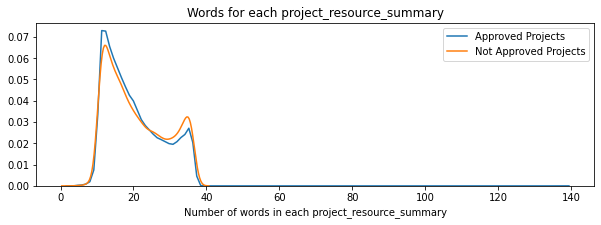

In [0]:
plt.figure(figsize=(10,3))
sns.distplot(approved_prs_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_prs_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each project_resource_summary')
plt.xlabel('Number of words in each project_resource_summary')
plt.legend()
plt.show()

### Summary:
1. Most of the projects contains 11 words.
2. In box plot, Median of word count in project resource summary is same in both approved and rejected projects.
3. Distribution of Not approved projects is slightly higher than the distribution of approved projects.

## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [0]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,154.6,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,299.0,1


In [0]:
# printing some random essays.
print(project_data['essay'].values[0])
print("-"*100)
print(project_data['essay'].values[150])
print("-"*100)
print(project_data['essay'].values[1000])
print("-"*100)
print(project_data['essay'].values[20000])
print("-"*100)
print(project_data['essay'].values[99999])
print("-"*100)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [0]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:07<00:00, 1626.40it/s]


In [0]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

### 1.3.2 Project title Text

In [0]:
# printing some random essays.
print(project_data['project_title'].values[0])
print("-"*100)
print(project_data['project_title'].values[150])
print("-"*100)
print(project_data['project_title'].values[1000])
print("-"*100)
print(project_data['project_title'].values[20000])
print("-"*100)
print(project_data['project_title'].values[99999])
print("-"*100)

Educational Support for English Learners at Home
----------------------------------------------------------------------------------------------------
More Movement with Hokki Stools
----------------------------------------------------------------------------------------------------
Sailing Into a Super 4th Grade Year
----------------------------------------------------------------------------------------------------
We Need To Move It While We Input It!
----------------------------------------------------------------------------------------------------
Inspiring Minds by Enhancing the Educational Experience
----------------------------------------------------------------------------------------------------


In [0]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:02<00:00, 38861.80it/s]


In [0]:
# after preprocesing
preprocessed_titles[20000]

'we need to move it while we input it'

## 1. 4 Preprocess catogorical features

In [0]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data


<ul>
<li>https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/</li>
</ul>

In [0]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

#### 1.4.1.1 Vectorizing project_subject_categories[clean_categories]

In [0]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())

categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


#### 1.4.1.2 Vectorizing project_subject_subcategories[clean_subcategories]

In [0]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())

sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


#### 1.4.1.3 Vectorizing school_state

In [0]:
#state
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())


states_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encodig ",states_one_hot.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encodig  (109248, 51)


#### 1.4.1.4 Vectorizing teacher_prefix

In [0]:
# removing Nan
# https://discuss.analyticsvidhya.com/t/how-to-handle-missing-values-of-categorical-variables/310/3
# Replacing the NaN values with 'Mrs' as it appears most frequently
# https://stackoverflow.com/a/39891994/10967428

#---------------------------------------------------------------------------------------
# Preprocessing Categorical Features: teacher_prefix
print(project_data['teacher_prefix'].value_counts())
print("="*100)

print(project_data[project_data['teacher_prefix'].isnull()]['teacher_prefix'])

print("="*100)
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
print(project_data['teacher_prefix'].value_counts())

print("="*100)
#---------------------------------------------------------------------------------------
#teacher prefix
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values)
print(vectorizer.get_feature_names())


teacher_prefixes_one_hot = vectorizer.transform(project_data['teacher_prefix'].values)
print("Shape of matrix after one hot encodig ",teacher_prefixes_one_hot.shape)

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64
7820     NaN
30368    NaN
57654    NaN
Name: teacher_prefix, dtype: object
Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64
['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher']
Shape of matrix after one hot encodig  (109248, 5)


#### 1.4.1.5 Vectorizing project_grade_category

In [0]:
#-------------------------------------------------------------------------------------------------------
# Preprocessing Categorical Features: project_grade_category
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-', '_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
#-------------------------------------------------------------------------------------------------------

#project_grade_category
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())

grades_categories_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",grades_categories_one_hot.shape)

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
Shape of matrix after one hot encodig  (109248, 4)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words on essay

In [0]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
essays_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",essays_bow.shape)

Shape of matrix after one hot encodig  (109248, 16623)


#### 1.4.2.2 Bag of Words on project_title

In [0]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
titles_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",titles_bow.shape)


Shape of matrix after one hot encodig  (109248, 3329)


#### 1.4.2.3 TFIDF vectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
essays_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",essays_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


#### 1.4.2.4 TFIDF Vectorizer on project_title

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
titles_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",titles_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 3329)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [0]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!

# ============================

words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

'\n# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n# ============================\nOutput:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n\n# ============================\n\nwords = []\nfor i in preproced_texts:\n    words.extend(i.split(\' \'))\n\nfor i in preproced_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(word

In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essay = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essay.append(vector)

print(len(avg_w2v_vectors_essay))
print(len(avg_w2v_vectors_essay[0]))

100%|██████████| 109248/109248 [00:39<00:00, 2787.52it/s]

109248
300


#### 1.4.2.6 Using Pretrained Models: AVG W2V on project_title

In [0]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles.append(vector)

print(len(avg_w2v_vectors_titles))
print(len(avg_w2v_vectors_titles[0]))

100%|██████████| 109248/109248 [00:01<00:00, 57095.29it/s]

109248
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words_essays = set(tfidf_model.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_essays = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_essays):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_essays.append(vector)

print(len(tfidf_w2v_vectors_essays))
print(len(tfidf_w2v_vectors_essays[0]))

100%|██████████| 109248/109248 [03:47<00:00, 480.56it/s]

109248
300


#### 1.4.2.9 Using Pretrained Models: TFIDF weighted W2V on project_title

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words_titles = set(tfidf_model.get_feature_names())

In [0]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_titles = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_titles):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles.append(vector)

print(len(tfidf_w2v_vectors_titles))
print(len(tfidf_w2v_vectors_titles[0]))

100%|██████████| 109248/109248 [00:05<00:00, 19874.73it/s]

109248
300


### 1.4.3 Vectorizing Numerical features

In [0]:
# price

# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 298.1193425966608, Standard deviation : 367.49634838483496


In [0]:
#quantity

# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

quantity_scalar = StandardScaler()
quantity_scalar.fit(project_data['quantity'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {quantity_scalar.mean_[0]}, Standard deviation : {np.sqrt(quantity_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
quantity_standardized = quantity_scalar.transform(project_data['quantity'].values.reshape(-1, 1))

Mean : 16.965610354422964, Standard deviation : 26.182821919093175


In [0]:
#teacher_num_pre_posted_projects

# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

teacher_num_pre_posted_projects_scalar = StandardScaler()
teacher_num_pre_posted_projects_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {teacher_num_pre_posted_projects_scalar.mean_[0]}, Standard deviation : {np.sqrt(teacher_num_pre_posted_projects_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
teacher_num_pre_posted_projects_standardized =teacher_num_pre_posted_projects_scalar.transform(project_data['quantity'].values.reshape(-1, 1))

Mean : 11.153165275336848, Standard deviation : 27.77702641477403


In [0]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [0]:

#categorial features 
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)
print("Shape of matrix after one hot encodig ",states_one_hot.shape)
print("Shape of matrix after one hot encodig ",teacher_prefixes_one_hot.shape)
print("Shape of matrix after one hot encodig ",grades_categories_one_hot.shape)
  
print("shape of title_bow:",titles_bow.shape)
print("shape of title_tfidf:",titles_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 9)
Shape of matrix after one hot encodig  (109248, 30)
Shape of matrix after one hot encodig  (109248, 51)
Shape of matrix after one hot encodig  (109248, 5)
Shape of matrix after one hot encodig  (109248, 4)
shape of title_bow: (109248, 3329)
shape of title_tfidf: (109248, 3329)


In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
#with the same hstack function we are concatinating a sparse matrix and a dense matirx 

X = hstack((categories_one_hot, 
            sub_categories_one_hot, 
            titles_bow, 
            price_standardized))
data_project_title_bow=hstack((categories_one_hot, 
                               sub_categories_one_hot,
                               states_one_hot,teacher_prefixes_one_hot,
                               grades_categories_one_hot,
                               quantity_standardized,
                               teacher_num_pre_posted_projects_standardized ,
                               price_standardized,titles_bow))
data_project_title_tfidf=hstack((categories_one_hot, 
                                 sub_categories_one_hot,
                                 states_one_hot,
                                 teacher_prefixes_one_hot,
                                 grades_categories_one_hot,
                                 quantity_standardized,
                                 teacher_num_pre_posted_projects_standardized ,
                                 price_standardized,
                                 titles_tfidf))
data_project_title_avg_w2v=hstack((categories_one_hot,
                                   sub_categories_one_hot,
                                   states_one_hot,
                                   teacher_prefixes_one_hot,
                                   grades_categories_one_hot,
                                   quantity_standardized,
                                   teacher_num_pre_posted_projects_standardized , 
                                   price_standardized,
                                   avg_w2v_vectors_titles))
data_project_title_tfidf_w2v=hstack((categories_one_hot,
                                     sub_categories_one_hot,
                                     states_one_hot,
                                     teacher_prefixes_one_hot,
                                     grades_categories_one_hot,
                                     quantity_standardized,
                                     teacher_num_pre_posted_projects_standardized ,
                                     price_standardized,
                                     tfidf_w2v_vectors_titles))

# Apply TSNE

1. The TSNE accepts only dense matrices
2. Consider only 5k to 6k data points to avoid memory issues. If you run into memory error issues, reduce the number of data points but clearly state the number of datat-poins you are using

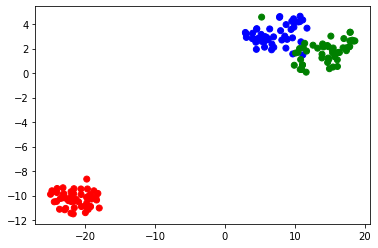

In [0]:
# this is the example code for TSNE
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris()
x = iris['data']
y = iris['target']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

In [0]:
#https://stackoverflow.com/a/54832428/10967428
X=data_project_title_bow
#converting COO to CSR
X=X.tocsr()
# taking 5000 data here due to memory constraint

X_data=X[0:5000,:]
#converting csr to dense 
X_data=X_data.toarray()

from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0,perplexity=100)
tsne_data_bow=model.fit_transform(X_data)
label_data=project_data['project_is_approved'].head(5000)
tsne_data_bow=np.vstack((tsne_data_bow.T,label_data)).T
tsne_data_bow_df=pd.DataFrame(tsne_data_bow,columns=('Dim-1','Dim-2','Label'))

print(tsne_data_bow_df.shape)

(5000, 3)


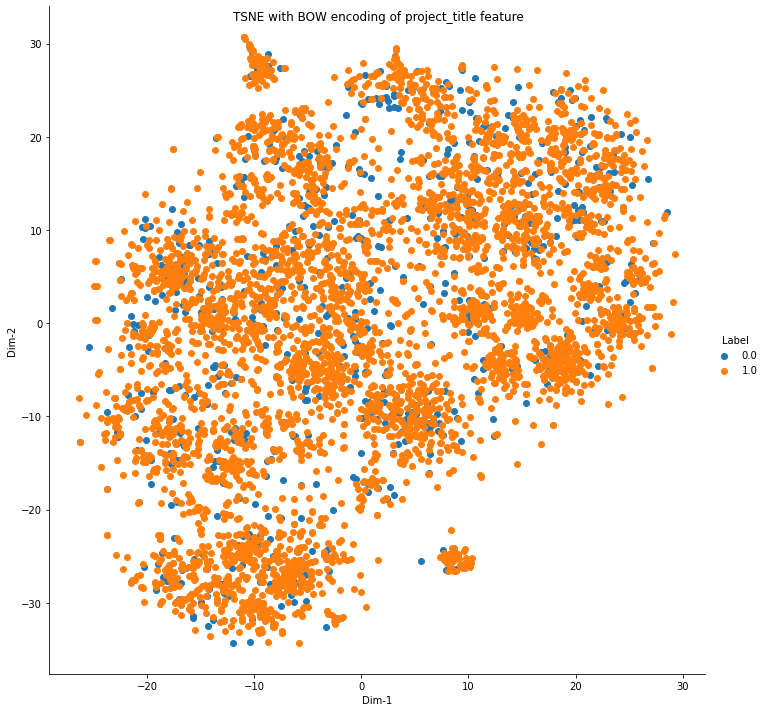

In [0]:
#https://stackoverflow.com/a/29814281/10967428
sns.FacetGrid(tsne_data_bow_df,hue='Label',size=10).\
map(plt.scatter,'Dim-1','Dim-2').add_legend().fig.suptitle('TSNE with BOW encoding of project_title feature')
plt.show()

<h2> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

In [0]:
X=data_project_title_tfidf
X=X.tocsr()
# taking 5000 data here due to memory constraint

X_data=X[0:5000,:]
#converting csr to dense 
X_data=X_data.toarray()


from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0,perplexity=100)
tsne_data_tfidf=model.fit_transform(X_data)
label_data=project_data['project_is_approved'].head(5000)
tsne_data_tfidf=np.vstack((tsne_data_tfidf.T,label_data)).T
tsne_data_tfidf_df=pd.DataFrame(tsne_data_tfidf,columns=('Dim-1','Dim-2','Label'))

print(tsne_data_tfidf_df.shape)

(5000, 3)


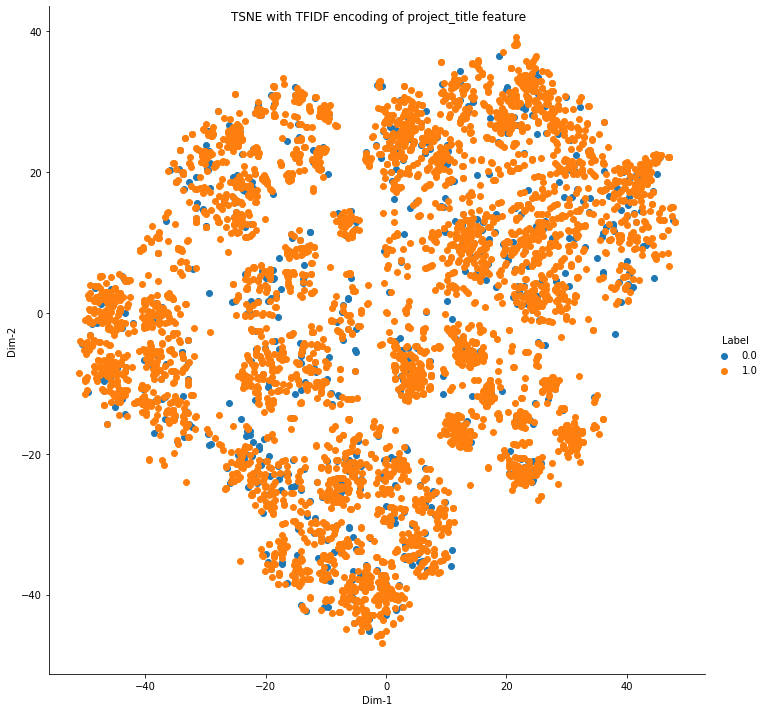

In [0]:
sns.FacetGrid(tsne_data_tfidf_df,hue='Label',size=10).\
map(plt.scatter,'Dim-1','Dim-2').add_legend().fig.suptitle('TSNE with TFIDF encoding of project_title feature')
plt.show()

<h2> 2.3 TSNE with `AVG W2V` encoding of `project_title` feature </h2>

In [0]:
X=data_project_title_avg_w2v

#X=hstack((categories_one_hot, sub_categories_one_hot,state_one_hot,teacher_prefix_one_hot,project_grade_cat_one_hot,quantity_standardized,teacher_num_pre_posted_projects_standardized , price_standardized,title_tfidf))
X=X.tocsr()
# taking 5000 data here due to memory constraint

X_data=X[0:5000,:]
#converting csr to dense 
X_data=X_data.toarray()


from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0,perplexity=100)
tsne_data_avg=model.fit_transform(X_data)
label_data=project_data['project_is_approved'].head(5000)
tsne_data_avg=np.vstack((tsne_data_avg.T,label_data)).T
tsne_data_avg_df=pd.DataFrame(tsne_data_avg,columns=('Dim-1','Dim-2','Label'))

print(tsne_data_avg_df.shape)

(5000, 3)


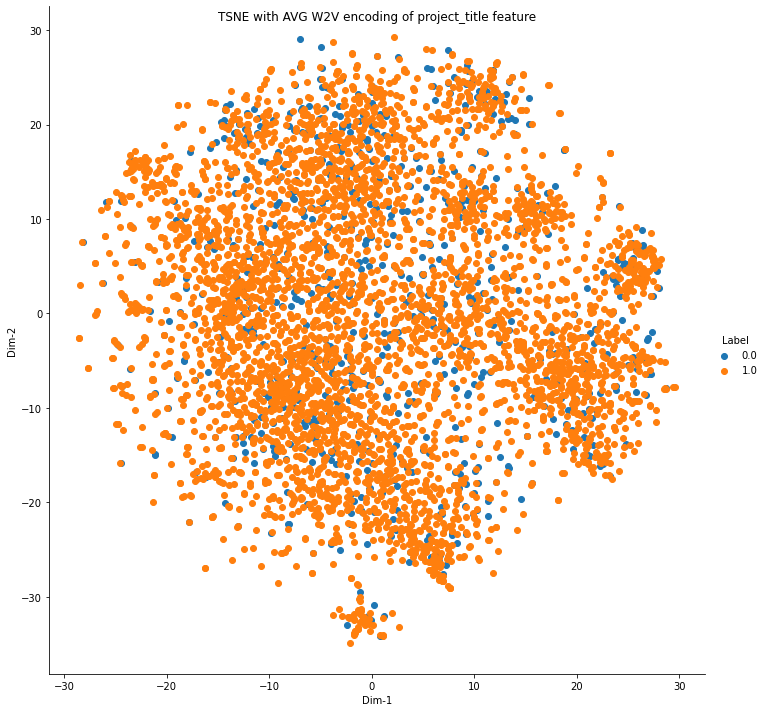

In [0]:
sns.FacetGrid(tsne_data_avg_df,hue='Label',size=10).\
map(plt.scatter,'Dim-1','Dim-2').add_legend().fig.suptitle('TSNE with AVG W2V encoding of project_title feature ')
plt.show()

<h2> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

In [0]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

X=data_project_title_tfidf_w2v

#X=hstack((categories_one_hot, sub_categories_one_hot,state_one_hot,teacher_prefix_one_hot,project_grade_cat_one_hot,quantity_standardized,teacher_num_pre_posted_projects_standardized , price_standardized,title_tfidf))
X=X.tocsr()
# taking 5000 data here due to memory constraint

X_data=X[0:5000,:]
#converting csr to dense 
X_data=X_data.toarray()


from sklearn.manifold import TSNE
model=TSNE(n_components=2,random_state=0,perplexity=100)
tsne_data_tfidfw=model.fit_transform(X_data)
label_data=project_data['project_is_approved'].head(5000)
tsne_data_tfidfw=np.vstack((tsne_data_tfidfw.T,label_data)).T
tsne_data_tfidfw_df=pd.DataFrame(tsne_data_tfidfw,columns=('Dim-1','Dim-2','Label'))

print(tsne_data_tfidf_df.shape)
##title_bow,title_tfidf,avg_w2v_vectors_title,tfidf_w2v_vectors_titles

(5000, 3)


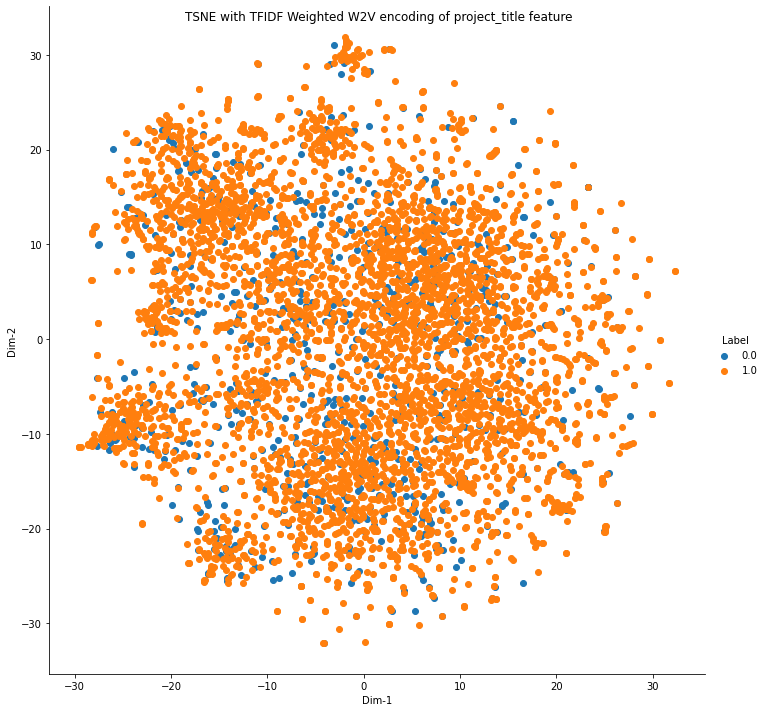

In [0]:
sns.FacetGrid(tsne_data_tfidfw_df,hue='Label',size=10).\
map(plt.scatter,'Dim-1','Dim-2').add_legend().fig.suptitle('TSNE with TFIDF Weighted W2V encoding of project_title feature')
plt.show()

**<h2> 2.5 Summary </h2>**

1. 85% of total projects i.e 92706 of 109248 are approved for funding 15 % of total projects failed to secure funding. It is an Imbalanced dataset.
2. Visulization of titles in project with Bag of words , TFIDF, avg Word2Vec, TFIDF weighted Word2Vec shows significant amount of overlaps and plots are not showing any clusters. So, We are not able to find any pattern in the data for classification.


**I have already mentioned the summary in each and every heading.**